# Biometrics 

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import tqdm.notebook as tqdm
import urllib

import dataset

from IPython.display import clear_output

%matplotlib inline

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/lyhtieYbxQOYqw'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
#!wget -O voxceleb.tar.gz "{download_url}"
#!tar -xf voxceleb.tar.gz

In [19]:
DEVICE = 'cuda:3' 
DATADIR = ''
FEATS = 80
LOADER_WORKERS = 8

In [ ]:
transform = torchaudio.transforms.MFCC(n_mfcc=FEATS)
trainset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_train'), transform)
testset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_test'), transform)
test_targets = pd.read_csv(os.path.join(DATADIR, 'target.csv')).values.tolist()

### Metrics


In [5]:
def cosine_similarity(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

In [6]:
def best_eer(data):
    full = sorted(data, key=lambda x: (x[0], -x[1]))
    pos = len([item for item in full if item[1] == 1])
    neg = len(full) - pos
    cur_pos = pos
    cur_neg = 0
    best_eer = 1
    for _, label in full:
        if label == 1:
            cur_pos -= 1
        else:
            cur_neg += 1
        cur_eer = max((pos - cur_pos) / pos, (neg - cur_neg) / neg)
        best_eer = min(best_eer, cur_eer)
    return best_eer

### Train

In [29]:
def train_stage(model, opt, batch_size: int = 256):
    loader = torch_data.DataLoader(
        trainset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    loss_sum = 0.0
    batches = 0
    for X, Y, _ in tqdm.tqdm(loader):
        logits, _ = model.forward(X.to(DEVICE), Y.to(DEVICE))
        loss = F.nll_loss(logits, Y.to(DEVICE))
        loss_sum += loss.item()
        batches += 1
        opt.zero_grad()
        loss.backward()
        opt.step()
    res = loss_sum / batches
    return res

In [8]:
def calc_eval_score(model: nn.Module, batch_size: int = 256):
    loader = torch_data.DataLoader(
        testset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    items = {}
    target_scores = []
    with torch.no_grad():
        for X, _, pathes in tqdm.tqdm(loader):
            _, embds = model.forward(X.to(DEVICE) , _.to(DEVICE))
            embds = embds.cpu().data.numpy().reshape(X.shape[0], -1)
            for embd, path in zip(embds, pathes):
                items[path] = embd
    for item1, item2, target in test_targets:
        target_scores.append((cosine_similarity(items[item1], items[item2]), target))
    return best_eer(target_scores)

In [31]:
def train(
    model: nn.Module,
    opt,
    scheduler=None,
    batch_size: int = 256,
    epochs: int = 25,
    train_fun = train_stage,
    train_kwargs = {},
):
    train_losses = []
    eval_scores = []
    for epoch in range(epochs):
        model.train()
        train_losses.append(train_fun(model, opt, batch_size=batch_size))
        model.eval()
        eval_scores.append(calc_eval_score(model, batch_size=batch_size))
        if scheduler and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step()  

        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train CE loss')
        axis[1].plot(np.arange(1, epoch + 2), eval_scores, label='eval')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='EER')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}. Train loss {train_losses[-1]}. Eval score {eval_scores[-1]}')

### ECAPA TDNN

In [36]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm1d(out_channels) 
        self.relu = nn.ReLU(inplace=True)       
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x))) 

class SEBlock(nn.Module):
    def __init__(self, input_shape: int, reduction: int):
        super().__init__()
        self.F_tr = ConvBlock(input_shape, input_shape * 2)
        self.F_sq = nn.AdaptiveAvgPool1d(1)
        self.F_ex1 = nn.Linear(input_shape * 2, input_shape * 2 // reduction)
        self.F_ex2 = nn.Linear(input_shape * 2 // reduction, input_shape * 2) 
        self.sigmoid = nn.Sigmoid()
        
    def __call__(self, X):
        X = self.F_tr(X)
        X_res = X.clone()
        batch_size, C, T = X.shape
        Z = self.F_sq(X)
        Z = self.F_sq(X).view(batch_size, C)
        Z = F.relu(self.F_ex1(Z))
        Z = self.F_ex2(Z)
        scale = self.sigmoid(Z).view(Z.size(0), Z.size(1), 1)
        X = (X * scale) + X_res
        return X

In [37]:
class Res2NetBlock(nn.Module):
    def __init__(self, input_channels, output_channels, num_groups):
        super(Res2NetBlock, self).__init__()
        self.num_groups = num_groups
        self.convs = nn.ModuleList([ConvBlock(input_channels, output_channels) for _ in range(num_groups)])

    def forward(self, X):
        B, G, C, T = X.shape  
        
        conv_outputs = []
        previous_output = None  
        
        for i in range(G):
            if i == 0:
                conv_outputs.append(X[:, i, :, :]) 
                previous_output = X[:, i, :, :] 
            else:
                current_input = X[:, i, :, :] + previous_output
                conv_output = self.convs[i](current_input)
                conv_outputs.append(conv_output)
                previous_output = conv_output  

        X_concat = torch.cat(conv_outputs, dim=1)  

        return X_concat       


class Res2Net(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale: int):
        super().__init__()
        assert hidden % (scale*2) == 0
        self.conv1 = nn.Conv1d(hidden, hidden//2, 1)
        self.scale = scale
        self.count_split = int(hidden / (scale*2))
        self.res2netblock = Res2NetBlock(self.count_split, self.count_split, self.scale)
        self.conv2 = nn.Conv1d(hidden//2, hidden, 1)
        
    def __call__(self, X):
        X_resudial = X.clone()
        X = self.conv1(X)
        B, C, T = X.shape
        X_split = X.view(B, self.scale, self.count_split, T)
        X_res = self.res2netblock(X_split)
        X_res = self.conv2(X_res) + X_resudial
        return X_res

In [38]:
class EcapaBlock(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale: int):
        super().__init__()
        self.conv1 = nn.Conv1d(hidden, hidden * 2, kernel_size = 3, padding = 1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden * 2)
        
        self.res2net = Res2Net(hidden*2, dilation = 2, scale = 4)
        
        self.conv2 = nn.Conv1d(hidden * 2, hidden, kernel_size = 3, padding = 1)
        self.relu = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden)
        
        self.se_block = SEBlock(hidden, reduction = 16)

        self.conv3 = nn.Conv1d(hidden * 2, hidden, kernel_size = 3, padding = 1)
        self.relu = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(hidden)
        
        
    def __call__(self, X):
        X = self.relu(self.bn1(self.conv1(X)))
        X = self.res2net(X)
        X = self.relu(self.bn2(self.conv2(X)))
        X = self.se_block(X)
        X = self.relu(self.bn3(self.conv3(X)))
        return X

In [39]:
import torch
import torch.nn as nn

class AttentiveStatsPooling(nn.Module):
    def __init__(self, input_shape: int, hidden: int):
        super(AttentiveStatsPooling, self).__init__()
        
        self.attention = nn.Sequential(
            nn.Linear(input_shape * 3, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, X):

        X = X.transpose(1, 2)
        
        B, T, F = X.shape
        
        mean = X.mean(dim=1, keepdim=True)  
        std = X.std(dim=1, keepdim=True)       
        
        mean_expanded = mean.expand(B, T, -1)
        std_expanded = std.expand(B, T, -1)
        X_cat = torch.cat([X, mean_expanded, std_expanded], dim=2) 
        
        attn_scores = self.attention(X_cat.view(B * T, -1)) 
        attn_weights = torch.softmax(attn_scores.view(B, T), dim=1)  
        
        weighted_mean = (attn_weights.unsqueeze(-1) * X).sum(dim=1) 
        
        diff_squared = (X - weighted_mean.unsqueeze(1)) ** 2
        weighted_std = torch.sqrt((attn_weights.unsqueeze(-1) * diff_squared).sum(dim=1) + 1e-9)  
        
        pooled = torch.cat([weighted_mean, weighted_std], dim=1) 
        return pooled

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AAMSoftmax(nn.Module):
    def __init__(self, input_shape, n_class, margin, scale):
        super(AAMSoftmax, self).__init__()
        self.margin = margin
        self.scale = scale
        self.n_class = n_class
        self.input_shape = input_shape
        self.weight = nn.Parameter(torch.FloatTensor(n_class, input_shape))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, X, y):
        X_norm = F.normalize(X, p=2, dim=1)
        W_norm = F.normalize(self.weight, p=2, dim=1)
        
        cosine = F.linear(X_norm, W_norm)
        cosine = cosine.clamp(-1.0, 1.0) 
        
        theta = torch.acos(cosine)
        
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, y.view(-1, 1), 1)
        
        cosine_margin = torch.cos(theta + self.margin)
        
        output = cosine * (1 - one_hot) + cosine_margin * one_hot
        
        output *= self.scale
        
        log_prob = torch.log_softmax(output, dim=1)
        return log_prob

In [41]:
class EcapaTDNN(nn.Module):
    def __init__(self, input_shape: int, hidden_shape: int,output_shape: int, n_class):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_shape, hidden_shape, kernel_size = 5, dilation = 1, padding = 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_shape)
        )
        self.ecapablock1 = EcapaBlock(hidden_shape, dilation = 2, scale = 2)
        self.ecapablock2 = EcapaBlock(hidden_shape, dilation = 2, scale = 3)
        self.ecapablock3 = EcapaBlock(hidden_shape, dilation = 2, scale = 4)
        self.conv2 = nn.Sequential(
            nn.Conv1d(hidden_shape * 3, hidden_shape * 3, kernel_size = 1, dilation = 1),
            nn.ReLU()
        )
        
        self.pooling_layer = AttentiveStatsPooling(input_shape=hidden_shape * 3, hidden=hidden_shape * 3 * 2)
        self.bn1 = nn.BatchNorm1d(output_shape)
        self.fc = nn.Linear(hidden_shape * 3 * 2, output_shape)
        self.faam = AAMSoftmax(input_shape=output_shape, n_class=n_class, margin=0.2, scale=30)


        

    def forward(self, X,y):
        X = self.conv1(X)
        X1 = self.ecapablock1(X)
        X2 = self.ecapablock2(X)
        X3 = self.ecapablock3(X)
    
        X = torch.cat([X1, X2, X3], dim=1) 
        X = self.conv2(X)
        X = self.pooling_layer(X)
        X = self.fc(X)
        emb = self.bn1(X)
        
        X = self.faam(emb,y)
        return X, emb

In [28]:
model = EcapaTDNN(FEATS, FEATS,192, trainset.speakers()).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")
print(len(trainset))

Total trainable parameters: 1,329,039
67785


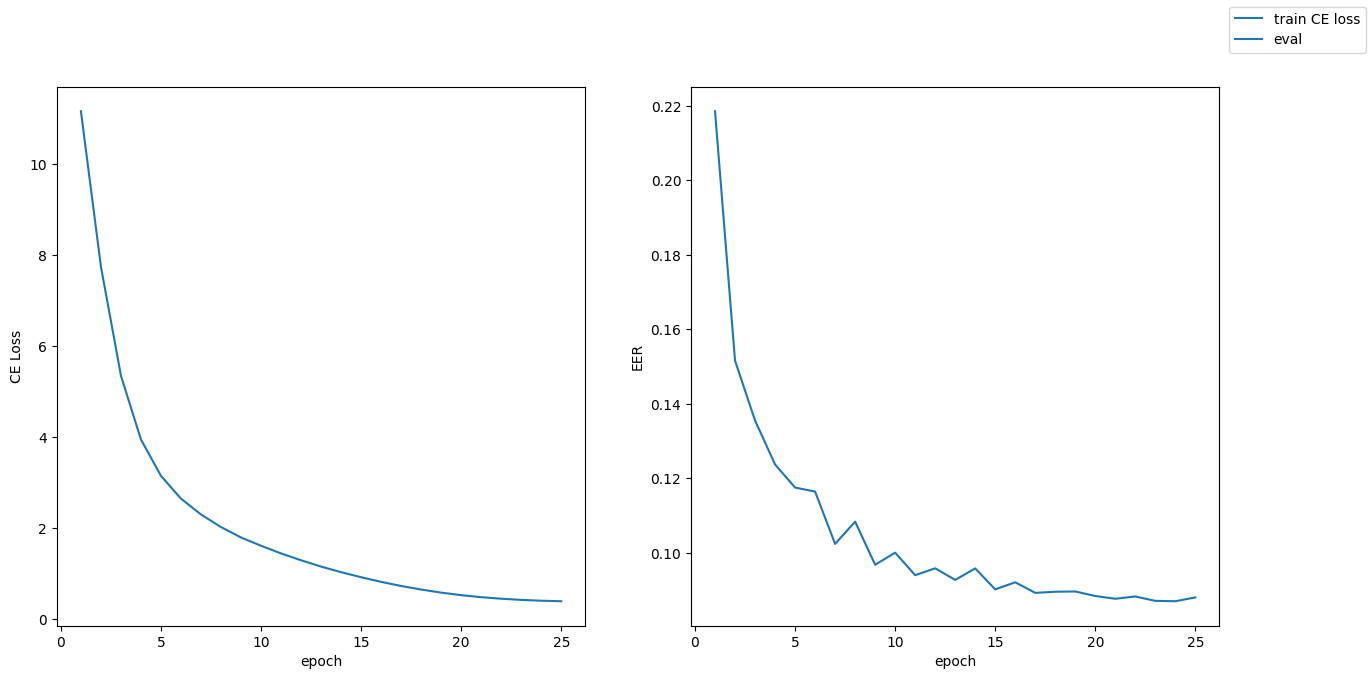

Epoch 25. Train loss 0.3922309032026327. Eval score 0.08805391315404666


In [33]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

model = EcapaTDNN(FEATS, FEATS, 192, trainset.speakers()).to(DEVICE)
opt = optim.Adam(model.parameters())
scheduler = CosineAnnealingLR(opt, T_max=25)

train(model, opt, scheduler, batch_size=128)

In [34]:
torch.save(model, 'model.pt')